In [ ]:
# !pip install kaggle
# import os
# from google.colab import files

# # Upload the kaggle.json file
# files.upload()

# # Move it to the correct directory
# os.makedirs('/root/.kaggle', exist_ok=True)
# !mv kaggle.json ~/.kaggle/

# # Set permissions
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
os.environ['KAGGLE_USERNAME']='YOUR_USERNAME'
os.environ['KAGGLE_KEY']='YOUR_KEY'

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset-v2

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2
License(s): GNU Lesser General Public License 3.0
 99% 376M/379M [00:04<00:00, 124MB/s] 
100% 379M/379M [00:04<00:00, 95.8MB/s]


In [ ]:
!unzip -q augmented-alzheimer-mri-dataset-v2.zip

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
train_dir = "data/train"
val_dir = "data/val"

# Image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def augment_data(class_name, required_images, data_gen, data_dir):
       class_path = os.path.join(data_dir, class_name)
       images = os.listdir(class_path)
       num_existing = len(images)

       temp_generator = data_gen.flow_from_directory(
           data_dir,
           target_size=(176, 176),
           batch_size=32,
           class_mode='categorical',
           classes=[class_name],
           save_to_dir=class_path,
           save_format="jpeg"
       )

       while num_existing < required_images:
           next(temp_generator)
           num_existing += 32

# Apply augmentation to balance training data
augment_data("MildDemented", 9600, train_datagen, train_dir)
augment_data("ModerateDemented", 9600, train_datagen, train_dir)
augment_data("VeryMildDemented", 9600, train_datagen, train_dir)

# Apply augmentation to balance validation data
augment_data("MildDemented", 3200, train_datagen, val_dir)
augment_data("ModerateDemented", 3200, train_datagen, val_dir)
augment_data("VeryMildDemented", 3200, train_datagen, val_dir)

print("Dataset balancing complete!")

Found 9600 images belonging to 1 classes.
Found 9600 images belonging to 1 classes.
Found 9600 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Dataset balancing complete!


In [ ]:
# Load balanced training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(176, 176),
    batch_size=32,
    class_mode="categorical"
)

# Get class distributions
train_classes, train_counts = np.unique(train_generator.classes, return_counts=True)
val_classes, val_counts = np.unique(val_generator.classes, return_counts=True)

# Print the number of images in each class
print("Training set distribution:", dict(zip(train_classes, train_counts)))
print("Validation set distribution:", dict(zip(val_classes, val_counts)))

Found 38400 images belonging to 4 classes.
Found 12800 images belonging to 4 classes.
Training set distribution: {np.int32(0): np.int64(9600), np.int32(1): np.int64(9600), np.int32(2): np.int64(9600), np.int32(3): np.int64(9600)}
Validation set distribution: {np.int32(0): np.int64(3200), np.int32(1): np.int64(3200), np.int32(2): np.int64(3200), np.int32(3): np.int64(3200)}


In [ ]:
import PIL
from PIL import Image

In [ ]:
image = Image.open("/content/data/train/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg")
width, height = image.size
print(f"Image size: {width} x {height} pixels") # Replace with the actual path to your image

Image size: 200 x 190 pixels


In [ ]:
base_model_inception = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(176, 176, 3)
)
base_model_densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(176, 176, 3)
)
shared_input = Input(shape=(176,176,3))

x_inception = base_model_inception(shared_input, training= False)
x_densenet = base_model_densenet(shared_input, training= False)


x_inception = tf.keras.layers.Flatten()(x_inception)
x_densenet = tf.keras.layers.Flatten()(x_densenet)

merged = tf.keras.layers.Concatenate()([x_inception, x_densenet])
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(merged)
x = BatchNormalization()(x)  # Batch Normalization to stabilize learning
x = Dropout(0.5)(x)  # Increased Dropout

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=shared_input,outputs=outputs)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 176, 176, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 4, 4, 2048)     │     21,802,784 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 5, 5, 1024)     │      7,037,504 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 32768)          │              0 │ inception_v3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 25600)          │              0 │ densenet121[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 58368)          │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │     29,884,928 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 512)            │          2,048 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 256)            │          1,024 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │          1,028 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 58,860,644 (224.54 MB)

 Trainable params: 58,741,028 (224.08 MB)

 Non-trainable params: 119,616 (467.25 KB)

In [ ]:
# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 809s 457ms/step - accuracy: 0.5050 - loss: 2.5711 - val_accuracy: 0.7366 - val_loss: 1.5723
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 530s 441ms/step - accuracy: 0.7241 - loss: 1.5692 - val_accuracy: 0.8305 - val_loss: 1.1785
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 531s 443ms/step - accuracy: 0.8251 - loss: 1.1342 - val_accuracy: 0.9166 - val_loss: 0.7611
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 530s 441ms/step - accuracy: 0.8732 - loss: 0.8125 - val_accuracy: 0.9102 - val_loss: 0.5920
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 530s 442ms/step - accuracy: 0.9132 - loss: 0.5682 - val_accuracy: 0.9023 - val_loss: 0.5180
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 530s 441ms/step - accuracy: 0.9333 - loss: 0.4259 - val_accuracy: 0.9405 - val_loss: 0.3653
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 531s 442ms/step - accuracy: 0.9476 - loss: 0.3311 - val_accuracy: 0.9664 - val_loss: 0.2457
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 530s 441ms/step - ac

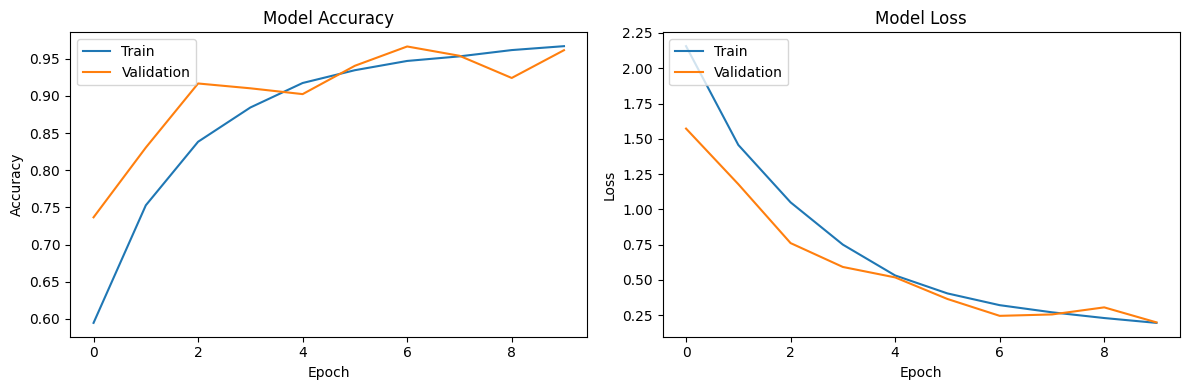

In [ ]:
# Visualize training results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-22-8b8b4a43a5b6>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


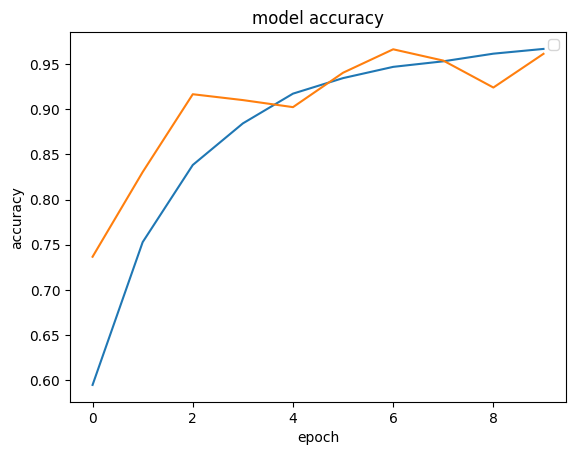

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

<ipython-input-23-80789450556a>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


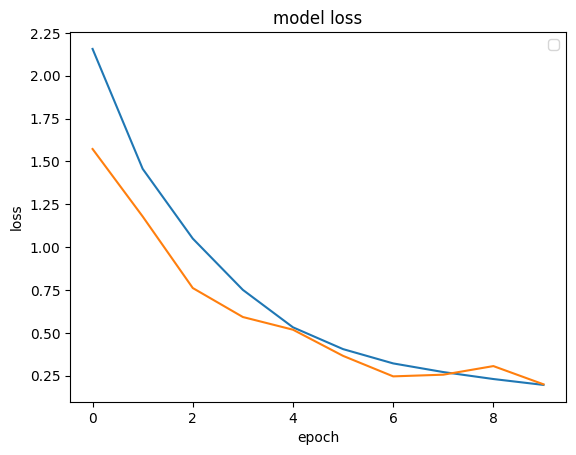

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

In [ ]:
y_pred_probs = model.predict(val_generator)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)     # Convert to predicted labels

400/400 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step


In [ ]:
y_true = val_generator.classes

In [ ]:
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr', average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Cohen's kappa: {kappa:.4f}")

Precision: 0.2611
Recall: 0.2611
F1-score: 0.2610
AUC: 0.5089
Cohen's kappa: 0.0148


Found 12800 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step


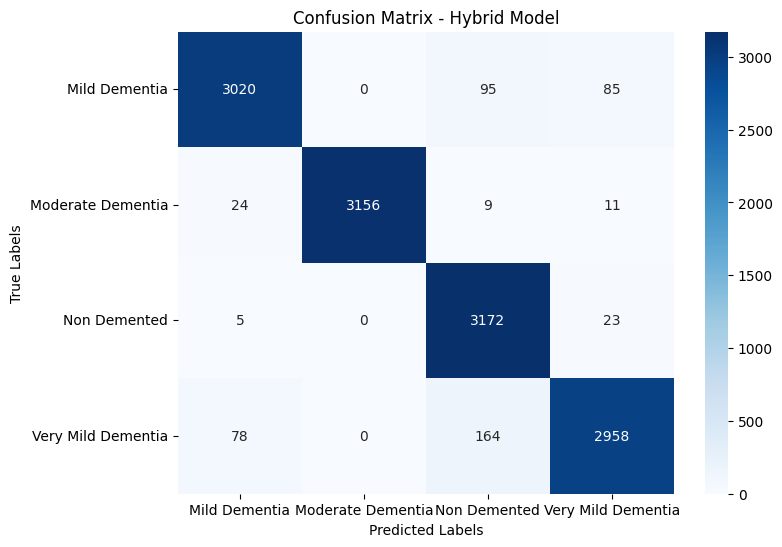

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure test data is preprocessed like training data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'data/val',  # Adjust path accordingly
    target_size=(176, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order of labels intact
)

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probability outputs to class labels

# Extract true labels from generator
y_true = test_generator.classes  # Matches the order of test_generator

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very Mild Dementia']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()
